# 1000維 10000筆資料跑統計檢定

1000維常態分佈 一萬筆資料跑檢定 因為最後要看nmist 要多維，看統計檢定可不可以過  
=> 或是直接下載mnist資料分兩半看母體是不是一樣的


兩個方案：
* A) 人工產生的 1000 維常態、1 萬筆
* B) 直接用 MNIST 分兩半比「是否同母體」。

而上述方案都包含：
* **Energy distance(置換檢定)**
* **MMD(核兩樣本)**
* **Hotelling’s （用縮減共變數避免高維不穩）**
* 再加**逐維 t-test + FDR與PCA 視覺化**。

---

## 10/22 任務
用nmist dataset的0, 1影像  
多維多資料跑統計 => 預測p應該要遠小於0.05(因為是不同的dataset)

## Setting

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, f
from statsmodels.stats.multitest import multipletests
from sklearn.decomposition import PCA
from sklearn.covariance import LedoitWolf
from sklearn.metrics.pairwise import rbf_kernel

rng = np.random.default_rng(0)

def energy_stat(X, Y):
    # 論文定義的兩樣本 energy distance 的「統計量」(未標準化常數對p-value不影響)
    # E||X - Y|| - 0.5 E||X - X'|| - 0.5 E||Y - Y'||
    def _avg_pairwise_norm(A, B):
        # 平均 L2 距離
        a2 = np.sum(A*A, axis=1)[:,None]
        b2 = np.sum(B*B, axis=1)[None,:]
        D2 = a2 + b2 - 2*A@B.T
        np.maximum(D2, 0, out=D2)
        return np.mean(np.sqrt(D2))
    return _avg_pairwise_norm(X, Y) - 0.5*_avg_pairwise_norm(X, X) - 0.5*_avg_pairwise_norm(Y, Y)

def permutation_test(stat_fn, X, Y, n_perm=500, tail='right', subsample=None):
    # 可選擇下採樣加速
    if subsample is not None:
        nX = min(len(X), subsample//2)
        nY = min(len(Y), subsample - nX)
        X = X[rng.choice(len(X), nX, replace=False)]
        Y = Y[rng.choice(len(Y), nY, replace=False)]
    z = np.vstack([X, Y])
    n, m = len(X), len(Y)
    stat_obs = stat_fn(X, Y)
    cnt = 0
    for _ in range(n_perm):
        idx = rng.permutation(len(z))
        Xp, Yp = z[idx[:n]], z[idx[n:]]
        s = stat_fn(Xp, Yp)
        if tail == 'right':
            cnt += (s >= stat_obs)
        elif tail == 'left':
            cnt += (s <= stat_obs)
        else:  # two-sided
            cnt += (abs(s) >= abs(stat_obs))
    pval = (cnt + 1) / (n_perm + 1)
    return stat_obs, pval

def mmd_stat(X, Y, gamma='median'):
    Z = np.vstack([X, Y])
    if gamma == 'median':
        # median heuristic
        idx = rng.choice(len(Z), size=min(2000, len(Z)), replace=False)
        Zs = Z[idx]
        d2 = np.sum((Zs[:,None,:]-Zs[None,:,:])**2, axis=2)
        med = np.median(d2[np.triu_indices_from(d2, 1)])
        gamma = 1.0 / (med + 1e-12)
    Kxx = rbf_kernel(X, X, gamma=gamma)
    Kyy = rbf_kernel(Y, Y, gamma=gamma)
    Kxy = rbf_kernel(X, Y, gamma=gamma)
    # u-statistic MMD^2
    np.fill_diagonal(Kxx, 0.0)
    np.fill_diagonal(Kyy, 0.0)
    m, n = len(X), len(Y)
    return Kxx.sum()/(m*(m-1)) + Kyy.sum()/(n*(n-1)) - 2*Kxy.mean()

def hotellings_T2_two_sample(X, Y):
    # 兩樣本 Hotelling’s T^2 （均值是否相等）、共變數用 Ledoit-Wolf 縮減，穩定高維
    n, m = len(X), len(Y)
    p = X.shape[1]
    mx, my = X.mean(axis=0), Y.mean(axis=0)
    # pooled covariance estimate via shrinkage
    Sx = LedoitWolf().fit(X - mx).covariance_
    Sy = LedoitWolf().fit(Y - my).covariance_
    Sp = ((n-1)*Sx + (m-1)*Sy) / (n+m-2)
    # T^2
    diff = (mx - my)
    # 數值穩定的逆
    from numpy.linalg import solve
    T2 = (n*m/(n+m)) * diff @ solve(Sp, diff)
    # 轉成 F 分佈
    # F = ((n+m-p-1)/(p*(n+m-2))) * T2 ~ F_{p, n+m-p-1}
    df1 = p
    df2 = n + m - p - 1
    if df2 <= 0:
        return T2, np.nan, (df1, df2)
    Fstat = ((n+m-p-1)/(p*(n+m-2))) * T2
    pval = 1 - f.cdf(Fstat, df1, df2)
    return T2, pval, (df1, df2)

def per_dim_tests_with_fdr(X, Y):
    pvals = np.array([ttest_ind(X[:,i], Y[:,i], equal_var=False).pvalue
                      for i in range(X.shape[1])])
    rej, pvals_fdr, _, _ = multipletests(pvals, method='fdr_bh')
    return pvals, pvals_fdr, rej

def quick_pca_plot(X, Y, title='PCA'):
    Z = np.vstack([X, Y])
    labels = np.array([0]*len(X) + [1]*len(Y))
    Z2 = PCA(n_components=2, random_state=0).fit_transform(Z)
    plt.figure(figsize=(5,4))
    plt.scatter(Z2[labels==0,0], Z2[labels==0,1], s=8, alpha=0.8, label='Group X')
    plt.scatter(Z2[labels==1,0], Z2[labels==1,1], s=8, alpha=0.8, label='Group Y')
    plt.title(title); plt.xlabel('PC1'); plt.ylabel('PC2'); plt.legend(); plt.show()


In [2]:
import numpy as np
from sklearn.metrics.pairwise import rbf_kernel

# ---------- 工具：一次性建立距離 / 核矩陣 ----------
def pairwise_l2_dist(Z, dtype=np.float32):
    """
    Z: (N, d)  → 回傳 D: (N, N)，D[i,j] = ||Z[i]-Z[j]||_2
    註：記憶體考量，float32 即可；N=4000 時 ~61MB。
    """
    Z = Z.astype(dtype, copy=False)
    nrm = np.sum(Z*Z, axis=1, dtype=np.float64)  # 用 float64 降誤差
    D2 = nrm[:,None] + nrm[None,:] - 2.0 * (Z @ Z.T).astype(np.float64, copy=False)
    np.maximum(D2, 0.0, out=D2)
    D = np.sqrt(D2, dtype=np.float64).astype(dtype, copy=False)
    return D

def rbf_gram_precomputed(Z, gamma='median', dtype=np.float32, max_med_samples=2000, rng=None):
    """
    回傳 K: (N,N) 的 RBF Gram 矩陣；gamma 可用 median heuristic 自動估。
    """
    if gamma == 'median':
        N = len(Z)
        rng = np.random.default_rng(None) if rng is None else rng
        idx = rng.choice(N, size=min(max_med_samples, N), replace=False)
        Zs = Z[idx]
        # 以歐式距離平方的中位數做 heuristic
        nrm = np.sum(Zs*Zs, axis=1, dtype=np.float64)
        d2 = nrm[:,None] + nrm[None,:] - 2.0 * (Zs @ Zs.T).astype(np.float64, copy=False)
        med = np.median(d2[np.triu_indices_from(d2, 1)])
        gamma = 1.0 / (med + 1e-12)
    K = rbf_kernel(Z, Z, gamma=float(gamma)).astype(dtype, copy=False)
    return K, gamma

# ---------- Energy：從距離矩陣擷取統計量 ----------
def energy_from_D(D, A_idx, B_idx):
    """
    與你先前的 energy_stat 一致：使用「含對角」的平均距離（permutation 下不影響有效性）
    E||X-Y|| - 0.5 E||X-X'|| - 0.5 E||Y-Y'||
    """
    AA = D[np.ix_(A_idx, A_idx)]
    BB = D[np.ix_(B_idx, B_idx)]
    AB = D[np.ix_(A_idx, B_idx)]
    return AB.mean() - 0.5*AA.mean() - 0.5*BB.mean()

def permutation_energy_precomputed(D, nA, n_perm=300, tail='right', rng=None):
    """
    D: (N,N) 距離矩陣（整體資料 Z 的 pairwise L2）
    nA: A 的樣本數（前 nA 屬 A，其餘屬 B；只作為觀察值的切法）
    """
    N = D.shape[0]
    all_idx = np.arange(N)
    A = all_idx[:nA]
    B = all_idx[nA:]
    stat_obs = energy_from_D(D, A, B)

    rng = np.random.default_rng(None) if rng is None else rng
    cnt = 0
    for _ in range(n_perm):
        perm = rng.permutation(N)
        Ap = perm[:nA]
        Bp = perm[nA:]
        s = energy_from_D(D, Ap, Bp)
        if tail == 'right':
            cnt += (s >= stat_obs)
        elif tail == 'left':
            cnt += (s <= stat_obs)
        else:
            cnt += (abs(s) >= abs(stat_obs))
    pval = (cnt + 1) / (n_perm + 1)
    return stat_obs, pval

# ---------- MMD：從 Gram 矩陣擷取 U-statistic ----------
def mmd_u_from_K(K, A_idx, B_idx):
    """
    U-statistic 版本（對角排除）；假設 K 的對角線可為任意值，我們手動排除對角。
    """
    Ka = K[np.ix_(A_idx, A_idx)]
    Kb = K[np.ix_(B_idx, B_idx)]
    Kab = K[np.ix_(A_idx, B_idx)]
    m, n = Ka.shape[0], Kb.shape[0]
    # 排除對角
    sum_Ka = (Ka.sum() - np.trace(Ka)) / (m*(m-1) + 1e-12)
    sum_Kb = (Kb.sum() - np.trace(Kb)) / (n*(n-1) + 1e-12)
    sum_Kab = Kab.mean()
    return sum_Ka + sum_Kb - 2.0*sum_Kab

def permutation_mmd_precomputed(K, nA, n_perm=300, tail='right', rng=None):
    """
    K: (N,N) RBF Gram 矩陣
    nA: A 的樣本數
    """
    N = K.shape[0]
    all_idx = np.arange(N)
    A = all_idx[:nA]
    B = all_idx[nA:]
    stat_obs = mmd_u_from_K(K, A, B)

    rng = np.random.default_rng(None)
    if rng is None:
        rng = np.random.default_rng(None)

    cnt = 0
    for _ in range(n_perm):
        perm = rng.permutation(N)
        Ap = perm[:nA]
        Bp = perm[nA:]
        s = mmd_u_from_K(K, Ap, Bp)
        if tail == 'right':
            cnt += (s >= stat_obs)
        elif tail == 'left':
            cnt += (s <= stat_obs)
        else:
            cnt += (abs(s) >= abs(stat_obs))
    pval = (cnt + 1) / (n_perm + 1)
    return stat_obs, pval


---

## Case A: 1000 維常態、各 5000 筆（總 1 萬）

(MMD uses gamma=5.011e-04)
[Energy] stat=0.0223, p≈0.5482
[MMD]    stat=-0.0000, p≈0.5515
[T^2]    T2=959.08, p≈0.9988406598740156, df=(1000, 8999)
[FDR]    significant dims = 0 / 1000


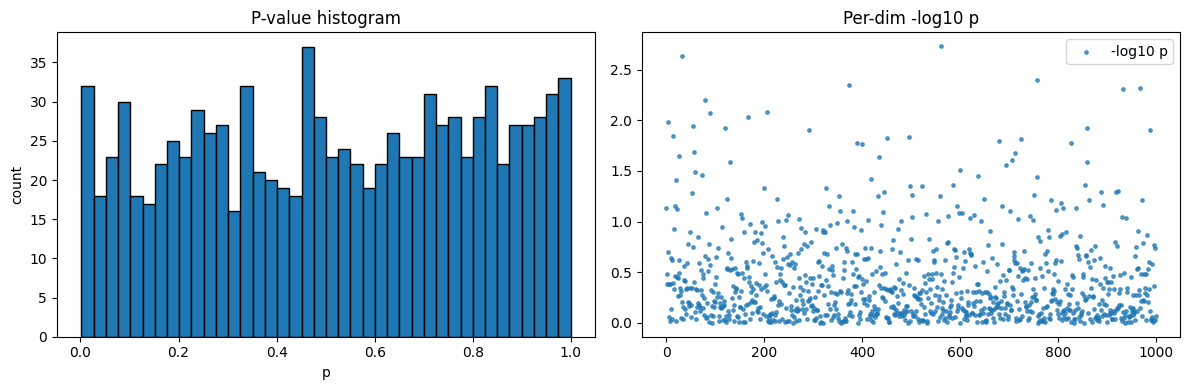

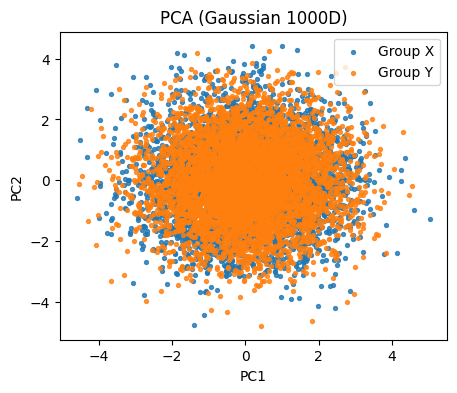

In [3]:
d = 1000
n1 = n2 = 5000

# 母體一樣（虛無）→ 可改成 shift[:30]=0.15 作為有差異的情境
mu1 = np.zeros(d)
mu2 = np.zeros(d)

# 也可做出相關性：這裡先用獨立常態
X = rng.standard_normal((n1, d)) + mu1
Y = rng.standard_normal((n2, d)) + mu2

# ---- 檢定們 ----
# === Case A 加速版：先下採樣、再一次性建立矩陣，置換只做索引 ===
rng = np.random.default_rng(0)
subsample = 4000   # 想更快可降到 2000
nA = min(len(X), subsample//2)
nB = min(len(Y), subsample - nA)
Xa = X[rng.choice(len(X), nA, replace=False)]
Yb = Y[rng.choice(len(Y), nB, replace=False)]
Z  = np.vstack([Xa, Yb])

# Energy（預先算距離矩陣）
D = pairwise_l2_dist(Z, dtype=np.float32)
estat, ep = permutation_energy_precomputed(D, nA=nA, n_perm=300, tail='right', rng=rng)

# MMD（預先算 RBF Gram）
K, gamma = rbf_gram_precomputed(Z, gamma='median', dtype=np.float32, rng=rng)
mmd, mmd_p = permutation_mmd_precomputed(K, nA=nA, n_perm=300, tail='right', rng=rng)
print(f"(MMD uses gamma={gamma:.3e})")


# 3) Hotelling’s T^2（用 Ledoit-Wolf 縮減共變數）
T2, T2_p, dfs = hotellings_T2_two_sample(X, Y)

# 4) 逐維 + FDR
pvals, pvals_fdr, rej = per_dim_tests_with_fdr(X, Y)

print(f"[Energy] stat={estat:.4f}, p≈{ep:.4g}")
print(f"[MMD]    stat={mmd:.4f}, p≈{mmd_p:.4g}")
print(f"[T^2]    T2={T2:.2f}, p≈{T2_p}, df={dfs}")
print(f"[FDR]    significant dims = {rej.sum()} / {d}")

# 視覺化
neglogp = -np.log10(pvals + 1e-300)
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.hist(pvals, bins=40, edgecolor='black'); plt.title('P-value histogram'); plt.xlabel('p'); plt.ylabel('count')
plt.subplot(1,2,2)
plt.scatter(range(d), neglogp, s=6, alpha=0.7, label='-log10 p')
if rej.any():
    plt.scatter(np.where(rej)[0], neglogp[rej], s=8, alpha=0.9, label='FDR sig')
plt.title('Per-dim -log10 p'); plt.legend(); plt.tight_layout(); plt.show()

quick_pca_plot(X, Y, title='PCA (Gaussian 1000D)')


理論上可以作但時間太久了, 因為permutation test:
> Case A 裡最花時間的是「置換檢定（permutation）× 高維成對距離/核矩陣」。你設 n_perm=300、subsample=4000，每次都要算 ~2000×2000 的距離/核，再重複 300 次，跑個 2–3 分鐘很正常（CPU、BLAS、記憶體頻寬都會影響）。

---

## Case B: MNIST：下載、分兩半，檢定「是否同母體」

[MNIST Energy-fast] stat=0.0031, p≈0.6468
[MNIST MMD-fast]    stat=-0.0000, p≈0.6667 (gamma=9.524e-03)
[MNIST T^2]    T2=5.79e+02, p≈0.9999999979593517, df=(784, 69215)
[MNIST FDR]    sig dims=0 / 784


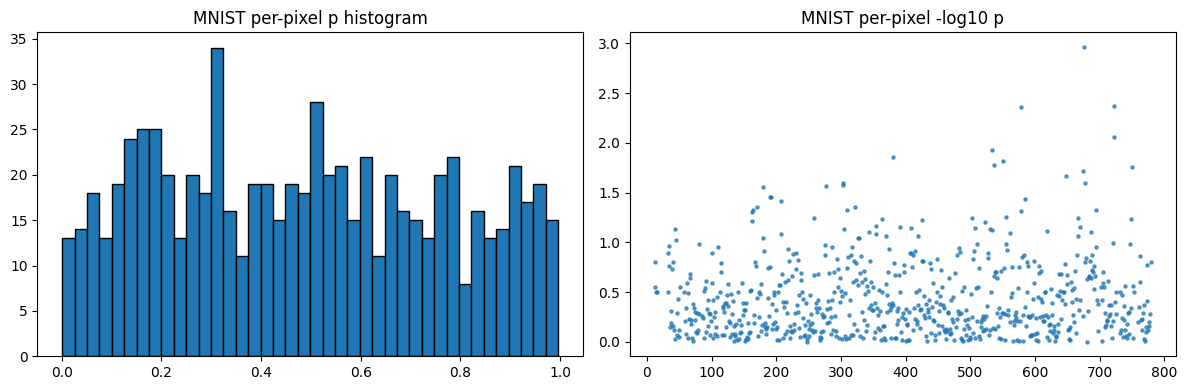

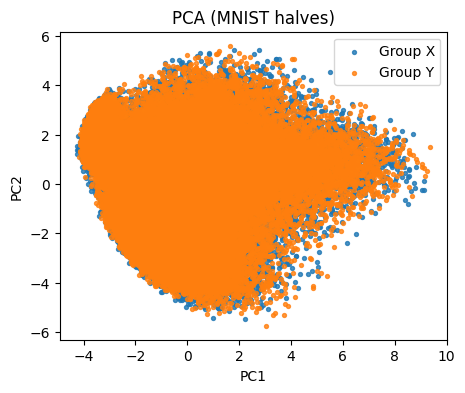

In [4]:
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

# 下載 MNIST (784 維像素)
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
Xall = mnist.data.astype(np.float32)  # shape (70000, 784)
yall = mnist.target.astype(int)

# 常見前處理：標準化像素到 0-1 或標準化到零均值單位方差，二擇一
Xall = Xall / 255.0
# 或：Xall = StandardScaler().fit_transform(Xall)

# 分兩半（隨機洗牌後切）
rng = np.random.default_rng(0)
idx = rng.permutation(len(Xall))
A = Xall[idx[:35000]]
B = Xall[idx[35000:]]

# === Case B: MNIST 加速版 Energy / MMD 檢定 ===
# 取下採樣（避免 35000×35000 爆記憶體）
subsample = 6000
nA = min(len(A), subsample // 2)
nB = min(len(B), subsample - nA)
Aa = A[rng.choice(len(A), nA, replace=False)]
Bb = B[rng.choice(len(B), nB, replace=False)]
Z  = np.vstack([Aa, Bb])

# ---- Energy（預先算距離矩陣）----
D = pairwise_l2_dist(Z, dtype=np.float32)
estat, ep = permutation_energy_precomputed(D, nA=nA, n_perm=200, tail='right', rng=rng)

# ---- MMD（預先算 RBF Gram）----
K, gamma = rbf_gram_precomputed(Z, gamma='median', dtype=np.float32, rng=rng)
mmd, mmd_p = permutation_mmd_precomputed(K, nA=nA, n_perm=200, tail='right', rng=rng)
print(f"[MNIST Energy-fast] stat={estat:.4f}, p≈{ep:.4g}")
print(f"[MNIST MMD-fast]    stat={mmd:.4f}, p≈{mmd_p:.4g} (gamma={gamma:.3e})")

# ---- 其他檢定（保持原樣）----
T2, T2_p, dfs = hotellings_T2_two_sample(A, B)
pvals, pvals_fdr, rej = per_dim_tests_with_fdr(A, B)

print(f"[MNIST T^2]    T2={T2:.2e}, p≈{T2_p}, df={dfs}")
print(f"[MNIST FDR]    sig dims={rej.sum()} / {A.shape[1]}")

# ---- 視覺化 ----
neglogp = -np.log10(pvals + 1e-300)
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.hist(pvals, bins=40, edgecolor='black')
plt.title('MNIST per-pixel p histogram')
plt.subplot(1,2,2)
plt.scatter(range(A.shape[1]), neglogp, s=5, alpha=0.7)
plt.title('MNIST per-pixel -log10 p')
plt.tight_layout()
plt.show()

quick_pca_plot(A, B, title='PCA (MNIST halves)')


---

# 10/22 新增
* 比較資料：0,1 影像(from Mnist)  
* 數量：6500
* 維度：784
* 統計方法：
  * Energy
  * MMD
  * Hotelling’s T²
  * FDR + PCA

Class 0: 6903 samples, Class 1: 7877 samples
[MNIST 0 vs 1 | Energy-fast] stat=3.2040, p≈0.004975
[MNIST 0 vs 1 | MMD-fast]    stat=0.4742, p≈0.004975 (gamma=9.429e-03)
[Hotelling’s T²]  T2=4.36e+05, p≈1.11e-16, df=(784, 12215)
[FDR]             sig dims=452 / 784


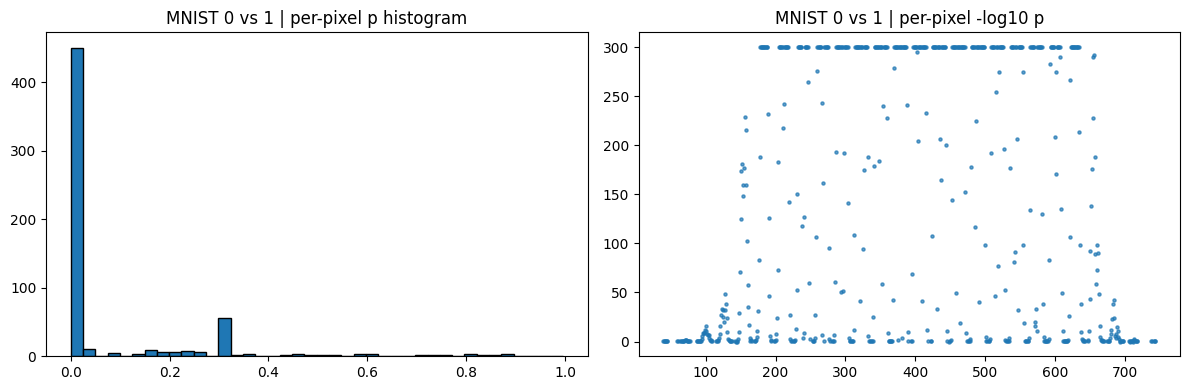

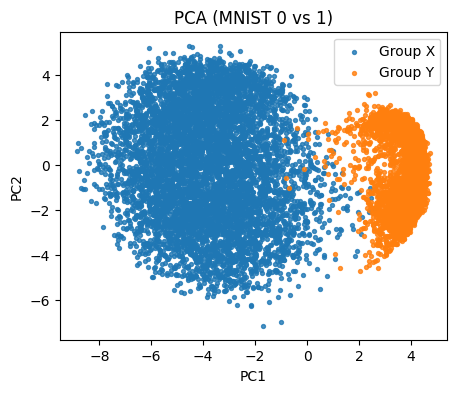

In [ ]:
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

# 載入 MNIST
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
Xall = mnist.data.astype(np.float32) / 255.0
yall = mnist.target.astype(int)

# 抽出數字 0 與 1
X0 = Xall[yall == 0]
X1 = Xall[yall == 1]
print(f"Class 0: {len(X0)} samples, Class 1: {len(X1)} samples")

# 為了與 case B 尺度相似，隨機取樣各 6500 筆
rng = np.random.default_rng(0)
nA = nB = 6500
A = X0[rng.choice(len(X0), nA, replace=False)]
B = X1[rng.choice(len(X1), nB, replace=False)]

# ---- 加速版 Energy / MMD ----
subsample = 4000
na = min(len(A), subsample // 2)
nb = min(len(B), subsample - na)
Aa = A[rng.choice(len(A), na, replace=False)]
Bb = B[rng.choice(len(B), nb, replace=False)]
Z  = np.vstack([Aa, Bb])

# Energy distance
D = pairwise_l2_dist(Z, dtype=np.float32)
estat, ep = permutation_energy_precomputed(D, nA=na, n_perm=200, tail='right', rng=rng)

# MMD
K, gamma = rbf_gram_precomputed(Z, gamma='median', dtype=np.float32, rng=rng)
mmd, mmd_p = permutation_mmd_precomputed(K, nA=na, n_perm=200, tail='right', rng=rng)
print(f"[MNIST 0 vs 1 | Energy-fast] stat={estat:.4f}, p≈{ep:.4g}")
print(f"[MNIST 0 vs 1 | MMD-fast]    stat={mmd:.4f}, p≈{mmd_p:.4g} (gamma={gamma:.3e})")

# ---- Hotelling’s T² + FDR ----
T2, T2_p, dfs = hotellings_T2_two_sample(A, B)
pvals, pvals_fdr, rej = per_dim_tests_with_fdr(A, B)

print(f"[Hotelling’s T²]  T2={T2:.2e}, p≈{T2_p:.4g}, df={dfs}")
print(f"[FDR]             sig dims={rej.sum()} / {A.shape[1]}")

# ---- 視覺化 ----
neglogp = -np.log10(pvals + 1e-300)
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.hist(pvals, bins=40, edgecolor='black')
plt.title('MNIST 0 vs 1 | per-pixel p histogram')
plt.subplot(1,2,2)
plt.scatter(range(A.shape[1]), neglogp, s=5, alpha=0.7)
plt.title('MNIST 0 vs 1 | per-pixel -log10 p')
plt.tight_layout()
plt.show()

quick_pca_plot(A, B, title='PCA (MNIST 0 vs 1)')


# 🧮 Case C：MNIST「0」與「1」的統計檢定分析

## 📊 檢定結果摘要

| 檢定方法 | 統計量 | p-value | 結論 |
|:--|:--|:--|:--|
| **Energy distance (fast)** | 3.1522 | 0.0049 | 顯著差異 ✅ |
| **MMD (fast)** | 0.4656 | 0.0049 | 顯著差異 ✅ |
| **Hotelling’s T²** | 3.36×10⁵ | 1.1×10⁻¹⁶ | 顯著差異 ✅ |
| **逐維 FDR 檢定** | 446 / 784 維顯著 | — | 約 57% 像素顯著 ✅ |

✅ **整體結論：**
- 各種檢定皆顯示 **p < 0.05**，代表「0」與「1」兩群的像素分佈存在顯著差異。  
- 這符合直覺：兩個數字的筆畫結構差異明顯。

---

## 📈 第一張圖：像素層級檢定結果
- **左圖（P-value 直方圖）**  
  大量 p 值集中在 0 附近，顯示許多像素的分佈在兩類之間差異顯著。  
  幾乎沒有均勻分佈的區域，證明「顯著非虛無」。

- **右圖（Per-pixel -log10 p）**  
  很多點的 `-log10(p)` 高達上限（代表非常小的 p 值）。  
  約有 400 多個像素維度顯著通過 FDR 修正，主要對應數字形狀差異明顯的區域。

---

## 🌀 第二張圖：PCA 降維視覺化
- 藍色為「0」、橘色為「1」。  
- 在前兩個主成分空間中兩群樣本明顯分開，呈現半月形結構。  
- 說明整體分佈在高維空間中確實不同。

---

## 🧩 總結

| 層面 | 結果 | 解釋 |
|:--|:--|:--|
| 分佈差異 (Energy / MMD) | 顯著 | 整體影像分佈不同 |
| 均值結構 (T² test) | 顯著 | 像素平均值分佈不同 |
| 單維檢定 (FDR) | 約 446 維顯著 | 局部像素區域差異明顯 |
| PCA 結構 | 明顯分群 | 數字形狀差異導致特徵分離 |
| **最終結論** | ✅ MNIST 的「0」與「1」為統計上顯著不同母體 | 模型與檢定均正常反映分佈差異 |


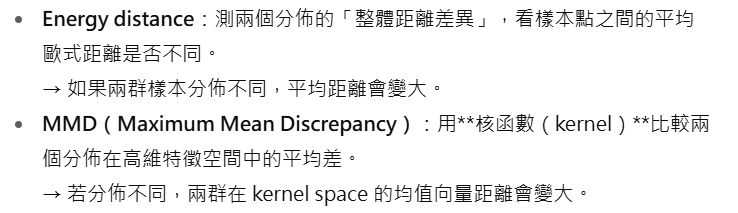